<code>calculate_RMSE_MAE_S2S_models_VRILE_days_vs_NONVRILE_days.ipynb</code>.  This notebook outputs RMSE and MAE for S2S model forecasts of sea ice extent and anomalous sea ice extent.  Model forecasts are separated into VRILE and non-VRILE days. 

### Load packages

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut

### Overview
Okay. Overview of our cross-validated, significance-tested VRILE error. 
* Load model netCDF files, combine with CTRL, and use common reforecast period.  Use data that has been regridded to the common land mask. 
    *  if NCEP, use entire period 
* Add aggregate regions 
* Create climatology--model: calculate date of year for valid date, lead time in weeks.
    *  Group by region, lead time, and valid date of year 
    *  Average climatology based on day of year and lead time in weeks--use <code>transform</code> to create <code>SIE_clim</code>.
    *  Subtract <code>SIE_clim</code> from <code>SIE</code>
* Create observed climatology based on common reforecast period (1999-2014)
* Set up LeaveOneOut cross-validation: We remove each year (1999-2014) from the observations.  Then we:
    * Calculate VRILEs excluding each year
    * Identify forecasts that correspond to VRILE days and separate S2S model data into VRILE days and non-VRILE days
    * Calculate errors: as a function of region, valid date, and lead time. 
    * Assess significance:
        * H0: RMSE for non-VRILE days = RMSE for VRILE days 
        * Calculate p-value: $p_0 = \frac{(RMSE_{VRILE} - RMSE_{NOVRILE})}{\sqrt{\frac{S_{VRILE}^2}{N_{VRILE}} + \frac{S_{NOVRILE}^2}{N_{NOVRILE}}}}$
        * Save p-values, standard deviations as a function of lead time, region, and year left out. 
        * When $|p| > |p_{crit}|$ ($p_{crit} = \pm 1.96$), we can say that the model's ability to predict sea ice on VRILE days is significantly different from the model's ability to predict sea ice on non-VRILE days in that region for that lead time while leaving out that year
  
* How many years must be significantly different for us to say our samples are overall different? Use a binomial test
    * $\sum_{i}^{N} {N \choose i}p^i(1 - p)^{N - i}$
    * N: total number of samples (15, one for each year between 1999-2014)
    * p: 0.5 (assume we have equal probability of rejecting or not-rejecting null hypothesis)
    * we need to find i: i = 13 for rejecting hypothesis at 95% confidence

In [2]:
from S2S_sea_ice_preprocess import load_model, create_aggregate_regions, create_model_climatology, create_obs_climatology
from S2S_sea_ice_VRILEs import get_VRILE_days
from S2S_sea_ice_metrics import calculate_errors, get_pvalues

<b>inputs:</b><br>
<li>  <code>model name</code>: (ecmwf,ukmo,ncep,metreofr) </li>
<li>  <code>seas_str</code>: [string for season; ALL if we want to do full year]</li>
<li>  <code>seas_sel</code>: [months of season; empty if we want to do full year] </li>
<li>  <code>vrile_thresh</code>: [threshhold at which VRILE is estimated </li>
<li>  <code>thresh_str</code>: [string for VRILE threshhold] </li>
<li>  <code>obs_name</code>: (NSIDC_0079, NSIDC_0051, OSISAF) [observational product we are using as our "truth"]</li>
<li>  <code>COMMON_RF</code>: boolean; indicates whether or not we want to use common reforecast period (1999-2014) or all available years (<code>True</code> is default)</li>
<li>  <code>nday_change</code>: $n$-day change in SIE for VRILE calculation (default is 5)</li>
<li>  <code>lead_weeks</code>: boolean; indicates whether or not we want our RMSE results to be as a function of lead days or lead weeks (default is <code>True</code>) </li>

### Set inputs

In [3]:
model_name = 'ncep'
seas_str = 'DJF'
seas_sel = [1,2,12]
obs_name = 'NSIDC_0079'
COMMON_RF = True
vrile_thresh = 0.05
thresh_str = '05'
nday_change = 5
lead_weeks = True
#
drop_last = True

Load model output for <code>model_name</code>

In [4]:
SIE = load_model(model_name)
print('loaded ',model_name)

loading files from  /home/disk/sipn/nicway/data/model/ncep/reforecast/sipn_nc_agg_commonland/
<xarray.Dataset>
Dimensions:       (ensemble: 3, fore_time: 43, init_time: 4523, nregions: 15)
Coordinates:
    region_names  (nregions) object dask.array<chunksize=(15,), meta=np.ndarray>
  * nregions      (nregions) int64 99 2 3 4 5 6 7 8 9 10 11 12 13 14 15
  * ensemble      (ensemble) int32 0 1 2
  * fore_time     (fore_time) timedelta64[ns] 1 days 2 days ... 42 days 43 days
  * init_time     (init_time) datetime64[ns] 1999-01-01 ... 2010-12-31
Data variables:
    Extent        (ensemble, init_time, fore_time, nregions) float64 dask.array<chunksize=(3, 16, 43, 15), meta=np.ndarray>
loaded  ncep


Create custom aggregate regions

In [5]:
SIE = create_aggregate_regions(SIE)
print('combined regions')
# Drop CTRL for METEOFR
if model_name == 'metreofr':
    SIEx = SIE.sel(ensemble=slice(0,8))

combined regions


Take the ensemble mean and get lead time in days

In [6]:
if model_name == 'metreofr':
    SIE_ens_mean = SIEx.mean(dim='ensemble')
else:
    SIE_ens_mean = SIE.mean(dim='ensemble')
regions = SIE.region_names
lead_days = SIE.fore_time.dt.days

Convert to DataFrame

In [7]:
SIE_df = SIE_ens_mean.to_dataframe().reset_index()

/home/disk/sipn/mcmcgraw/anaconda3/envs/sea_ice_variability_S2S/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Calculate the date for forecasts by adding the <code>fore_time</code> to <code>init_time</code>. Rename some columns.

In [8]:
SIE_df['valid date'] = SIE_df['init_time'] + SIE_df['fore_time']
SIE_df = SIE_df.rename(columns={'region_names':'region',
                           'fore_time':'lead time (days)',
                           'init_time':'init date',
                           'Extent':'SIE'})

Create lead-dependent climatology for model output.  Decide how long we want weeks to be for weekly climatology (default is 7 days)

In [9]:
week_length = 7
SIE_df = create_model_climatology(SIE_df,7)
print('model climatology created')

model climatology created


Load observations.  <code>NSIDC_0079</code> is NASA Bootstrap, <code>NSIDC_0051</code> is NASA team (NOTE we only have Bootstrap on the common land mask)

In [10]:
if obs_name == 'NSIDC_0079':
    obs_type = 'sipn_nc_yearly_agg_commonland'
elif obs_name == 'NSIDC_0051':
    obs_type = 'sipn_nc_yearly_agg'
elif obs_name == 'OSISAF':
    print('come back later')
filepath = '/home/disk/sipn/nicway/data/obs/{model_name}/{model_type}/'.format(model_name=obs_name,
                                                                              model_type=obs_type)
print('loading obs from ',filepath)
obs_filenames = xr.open_mfdataset(filepath+'/*.nc',concat_dim='time')
print('opening ',obs_filenames)
obs_SIE = obs_filenames.Extent
obs_regions = obs_filenames.nregions
obs_region_names = obs_filenames['region_names'].values
# Drop region names and re-add as a non-dask.array object.  This is stupid but oh well
obs_SIE = obs_SIE.drop('region_names')
obs_SIE["region_names"] = ("nregions",obs_region_names)
print('obs loaded')

loading obs from  /home/disk/sipn/nicway/data/obs/NSIDC_0079/sipn_nc_yearly_agg_commonland/
opening  <xarray.Dataset>
Dimensions:       (nregions: 15, time: 11627)
Coordinates:
    region_names  (nregions) object dask.array<chunksize=(15,), meta=np.ndarray>
  * nregions      (nregions) int64 99 2 3 4 5 6 7 8 9 10 11 12 13 14 15
  * time          (time) datetime64[ns] 1989-01-01 1989-01-02 ... 2020-10-31
Data variables:
    Extent        (time, nregions) float64 dask.array<chunksize=(365, 15), meta=np.ndarray>
obs loaded


/home/disk/sipn/mcmcgraw/anaconda3/envs/sea_ice_variability_S2S/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  # Remove the CWD from sys.path while we load stuff.
/home/disk/sipn/mcmcgraw/anaconda3/envs/sea_ice_variability_S2S/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
befo

Add aggregate regions to obs and convert obs to Pandas dataframe

In [11]:
obs_SIE = create_aggregate_regions(obs_SIE)
obs_SIE = obs_SIE.to_dataframe().reset_index()
obs_SIE = obs_SIE.rename(columns={'Extent':'SIE','region_names':'region','time':'valid date'})
if obs_name == 'OSISAF':
    obs_SIE['valid date'] = pd.to_datetime(obs_SIE['valid date']).dt.date

Cool. Calculate our observed climatology using static climatology. Use only common reforecast years (1999-2014, inclusive) unless <code>COMMON_RF = False</code>

In [12]:
if COMMON_RF == True:
    obs_SIE = obs_SIE[pd.to_datetime(obs_SIE['valid date']).dt.year.isin(np.arange(1999,2015))]
    obs_SIE = create_obs_climatology(obs_SIE)
    time_str = 'COMMON_RF'
    print('common reforecast')
else:
    time_str = 'FULL_PERIOD'
    obs_SIE = create_obs_climatology(obs_SIE)
    print('full period')
print('observed climatology created')
obs_SIE['valid year'] = pd.to_datetime(obs_SIE['valid date']).dt.year


common reforecast
observed climatology created


Sanity check time: pick a date, and plot $n$ day model forecasts for that date as well as the next $n$ days of obs ($n$ = length of model forecasts (btw 45 and 60).  Generally speaking, model and obs should have some difference right at the beginning (initialization errors), error may decrease a bit in the first few days of the forecast period, and then at the end of the period it will increase again. 

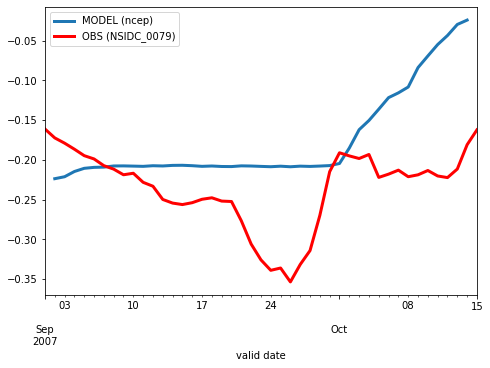

In [13]:
if model_name == 'metreofr':
    date_sel = pd.to_datetime('08-30-2007')
elif model_name == 'ecmwf':
    date_sel = pd.to_datetime('09-03-2007')
else:
    date_sel = pd.to_datetime('09-01-2007')
reg_sel = 'Central Arctic'
SIE_date_sel = SIE_df.where((SIE_df['init date'] == date_sel) & (SIE_df['region']==reg_sel)).dropna(how='all')
fig1 = plt.figure(1)
ax1 = fig1.add_axes([0,0,1,1])
SIE_date_sel.plot(x='valid date',y='SIE anom',ax=ax1,linewidth=3,label='MODEL ({model_name})'.format(model_name=model_name))
obs_sel = obs_SIE[obs_SIE['valid date'].isin(pd.date_range(start=date_sel,end=date_sel+SIE_df['lead time (days)'].max()))]
obs_sel = obs_sel.where(obs_sel['region']==reg_sel).dropna(how='all')
obs_sel.plot(x='valid date',y='SIE anom',ax=ax1,color='r',linewidth=3,label='OBS ({obs_name})'.format(obs_name=obs_name))

In [14]:
import warnings;
warnings.filterwarnings('ignore'); # so the warnings don't drive me insane

### Calculate Forecast Error on VRILE Days and non-VRILE Days using LeaveOneOut Cross-Validation
Now, we begin the LeaveOneOut process as our cross-validation.  Since we have only 15 years in our common reforecast period, we'll use a LeaveOneOut, as our training dataset is relatively small (since VRILEs are only 5% of the data). 

NOTE: Though <code>sklearn</code> has a <code>LeaveOneOut</code> functionality, it doesn't play well with <code>groupby</code> and some of the other functions we use, so we will just do the LOO cross-validation by hand, at least for now.  

#### Initialize empty dataframes

Drop St John, Sea of Okhotsk

In [15]:
if seas_str == 'JAS':
    regions_drop = ['Sea of Okhotsk','St John','Bering']
elif seas_str == 'JJA':
    regions_drop = ['Sea of Okhotsk','St John']
else:
    regions_drop = ['St John']
obs_SIE = obs_SIE[~obs_SIE['region'].isin(regions_drop)]
SIE_df = SIE_df[~SIE_df['region'].isin(regions_drop)]

In [16]:
SIE_errors_ALL = pd.DataFrame()
SIE_anom_errors_ALL = pd.DataFrame()
SIE_errors_NO_ALL = pd.DataFrame()
SIE_anom_errors_NO_ALL = pd.DataFrame()
#
SIE_reg = SIE_df.set_index(['region'])
regions_list = SIE_df['region'].unique().tolist()
#
pvalues_SIE = pd.DataFrame()
pvalues_SIE_anom = pd.DataFrame()

In [17]:
week_length = 7
if (model_name != 'ukmo') & (drop_last == True):
    max_fore = SIE_reg['lead time (days)'].max()
    SIE_reg = SIE_reg.where(SIE_reg['lead time (days)'] < max_fore).dropna(how='all')
#SIE_reg.groupby(['region','lead time (days)'])['SIE'].mean().xs('East Siberian-Beaufort-Chukchi Sea')#.plot()

#### Calculation time--omit one year from the data set, separate data into VRILE and non-VRILE days, and calculate forecast error. Repeat. 
(Note, this current implementation uses too many loops; feel free to upgrade)

In [18]:
yrs = obs_SIE['valid year'].unique().tolist()
for iyr in yrs:
    #iyr = 1999
    # Remove iyr from obs
    obs_SIE_sel = obs_SIE[~obs_SIE['valid year'].isin([iyr])]
    print('leaving out ',iyr)
    # Estimate observed VRILE days (without iyr)
    obs_SIE_VRILE_onlyx, obs_SIE_anom_VRILE_onlyx, obs_SIE_NO_VRILEx, obs_SIE_anom_NO_VRILEx = get_VRILE_days(obs_SIE_sel,vrile_thresh,nday_change,seas_sel)
    print('VRILE days calculated')
    obs_SIE_VRILE_only = obs_SIE_VRILE_onlyx.set_index(['region'])
    obs_SIE_anom_VRILE_only = obs_SIE_anom_VRILE_onlyx.set_index(['region'])
    #
    obs_SIE_NO_VRILE = obs_SIE_NO_VRILEx.set_index(['region'])
    obs_SIE_anom_NO_VRILE = obs_SIE_anom_NO_VRILEx.set_index(['region'])
    # Now, we want to compare model forecasts on VRILE days to model forecasts on non-VRILE days
    SIE_no_VRILES = pd.DataFrame()
    SIE_anom_no_VRILES = pd.DataFrame()
    #
    SIE_VRILES = pd.DataFrame()
    SIE_anom_VRILES = pd.DataFrame()
    # Get SIE forecasts on VRILE and non-VRILE days for each region.  Loop through regions. 
    for i_region in regions_list:
        # Skip St John because it's crazy
        if i_region == 'St John':
            continue
        SIE_ivrile = SIE_reg.loc[i_region][pd.to_datetime(SIE_reg.loc[i_region]['valid date']).isin(pd.to_datetime(obs_SIE_VRILE_only.loc[i_region]['valid date']))]
        SIE_VRILES = SIE_VRILES.append(SIE_ivrile)
        #
        SIE_anom_ivrile = SIE_reg.loc[i_region][pd.to_datetime(SIE_reg.loc[i_region]['valid date']).isin(pd.to_datetime(obs_SIE_anom_VRILE_only.loc[i_region]['valid date']))]
        SIE_anom_VRILES = SIE_anom_VRILES.append(SIE_anom_ivrile)
        #
        if (obs_SIE_NO_VRILE.loc[i_region].shape[0] == 16):
            continue
        SIE_no_ivrile = SIE_reg.loc[i_region][pd.to_datetime(SIE_reg.loc[i_region]['valid date']).isin(pd.to_datetime(obs_SIE_NO_VRILE.loc[i_region]['valid date']))]
        SIE_no_VRILES = SIE_no_VRILES.append(SIE_no_ivrile)
        #
        SIE_anom_no_ivrile = SIE_reg.loc[i_region][pd.to_datetime(SIE_reg.loc[i_region]['valid date']).isin(pd.to_datetime(obs_SIE_anom_NO_VRILE.loc[i_region]['valid date']))]
        SIE_anom_no_VRILES = SIE_anom_no_VRILES.append(SIE_anom_no_ivrile)
    # Now, we get lead time in weeks because ultimately we're going to plot as a function of week 
    SIE_anom_VRILES['lead time (weeks)'] = np.floor(SIE_anom_VRILES['lead time (days)'].dt.days/week_length)
    SIE_VRILES['lead time (weeks)'] = np.floor(SIE_VRILES['lead time (days)'].dt.days/week_length)
    SIE_anom_no_VRILES['lead time (weeks)'] = np.floor(SIE_anom_no_VRILES['lead time (days)'].dt.days/week_length)
    SIE_no_VRILES['lead time (weeks)'] = np.floor(SIE_no_VRILES['lead time (days)'].dt.days/week_length)
    # Calculate RMSE and MAE for sea ice forecasts
    if lead_weeks == True:
        clim_freq_str = 'WEEKLY'
        SIE_VRILES['lead days'] = SIE_VRILES['lead time (weeks)']
        SIE_anom_VRILES['lead days'] = SIE_anom_VRILES['lead time (weeks)']
        SIE_raw_err,SIE_errors = calculate_errors(SIE_VRILES,obs_SIE_VRILE_only)
        SIE_anom_raw_err,SIE_anom_errors = calculate_errors(SIE_anom_VRILES,obs_SIE_anom_VRILE_only)
        ## NO VRILES
        SIE_no_VRILES['lead days'] = SIE_no_VRILES['lead time (weeks)']
        SIE_anom_no_VRILES['lead days'] = SIE_anom_no_VRILES['lead time (weeks)']
        SIE_raw_err_NO,SIE_errors_NO = calculate_errors(SIE_no_VRILES,obs_SIE_NO_VRILE)
        SIE_anom_raw_err_NO,SIE_anom_errors_NO = calculate_errors(SIE_anom_no_VRILES,obs_SIE_anom_NO_VRILE)
    else:
        clim_freq_str = 'DAILY'
        SIE_VRILES['lead days'] = SIE_VRILES['lead time (days)'].dt.days
        SIE_anom_VRILES['lead days'] = SIE_anom_VRILES['lead time (days)'].dt.days
        SIE_raw_err,SIE_errors = calculate_errors(SIE_VRILES,obs_SIE_VRILE_only)
        SIE_anom_raw_err,SIE_anom_errors = calculate_errors(SIE_anom_VRILES,obs_SIE_anom_VRILE_only)
        ## NO VRILES
        SIE_no_VRILES['lead days'] = SIE_no_VRILES['lead time (days)'].dt.days
        SIE_anom_no_VRILES['lead days'] = SIE_anom_no_VRILES['lead time (days)'].dt.days
        SIE_raw_err_NO,SIE_errors_NO = calculate_errors(SIE_no_VRILES,obs_SIE_NO_VRILE)
        SIE_anom_raw_err_NO,SIE_anom_errors_NO = calculate_errors(SIE_anom_no_VRILES,obs_SIE_anom_NO_VRILE)
    print('errors calculated')

    # Get p-values
    sd_VRILE,sd_noVRILE,p_value,N_vrile,N_novrile = get_pvalues(SIE_VRILES,SIE_no_VRILES,SIE_errors,SIE_errors_NO)
    sd_VRILE_anom,sd_noVRILE_anom,p_value_anom,N_vrile_anom,N_novrile_anom = get_pvalues(SIE_anom_VRILES,
                                                            SIE_anom_no_VRILES,SIE_anom_errors,SIE_anom_errors_NO)

    # Add information to dataframes
    SIE_errors['year out'] = iyr
    SIE_errors['SIE sdev'] = sd_VRILE
    SIE_errors['sample size'] = N_vrile
    SIE_errors['p-value'] = p_value
    SIE_errors_NO['year out'] = iyr
    SIE_errors_NO['SIE sdev'] = sd_noVRILE
    SIE_errors_NO['sample size'] = N_novrile
    SIE_errors_NO['p-value'] = p_value
    #
    SIE_anom_errors['year out'] = iyr
    SIE_anom_errors['SIE sdev'] = sd_VRILE_anom
    SIE_anom_errors['sample size'] = N_vrile_anom
    SIE_anom_errors['p-value'] = p_value_anom
    SIE_anom_errors_NO['year out'] = iyr
    SIE_anom_errors_NO['SIE sdev'] = sd_noVRILE_anom
    SIE_anom_errors_NO['sample size'] = N_novrile_anom
    SIE_anom_errors_NO['p-value'] = p_value_anom
    # Append each CV slice to full data set
    SIE_errors_ALL = SIE_errors_ALL.append(SIE_errors)
    SIE_anom_errors_ALL = SIE_anom_errors_ALL.append(SIE_anom_errors)
    SIE_errors_NO_ALL = SIE_errors_NO_ALL.append(SIE_errors_NO)
    SIE_anom_errors_NO_ALL = SIE_anom_errors_NO_ALL.append(SIE_anom_errors_NO)

leaving out  1999
VRILE days calculated
errors calculated
leaving out  2000
VRILE days calculated
errors calculated
leaving out  2001
VRILE days calculated
errors calculated
leaving out  2002
VRILE days calculated
errors calculated
leaving out  2003
VRILE days calculated
errors calculated
leaving out  2004
VRILE days calculated
errors calculated
leaving out  2005
VRILE days calculated
errors calculated
leaving out  2006
VRILE days calculated
errors calculated
leaving out  2007
VRILE days calculated
errors calculated
leaving out  2008
VRILE days calculated
errors calculated
leaving out  2009
VRILE days calculated
errors calculated
leaving out  2010
VRILE days calculated
errors calculated
leaving out  2011
VRILE days calculated
errors calculated
leaving out  2012
VRILE days calculated
errors calculated
leaving out  2013
VRILE days calculated
errors calculated
leaving out  2014
VRILE days calculated
errors calculated


Some more sanity check plots. Make sure our basic RMSEs look right (should be generally increasing with lead time for non-VRILE days; VRILE days might look more wonky.  We'll do an individual fold first, then all folds together. 

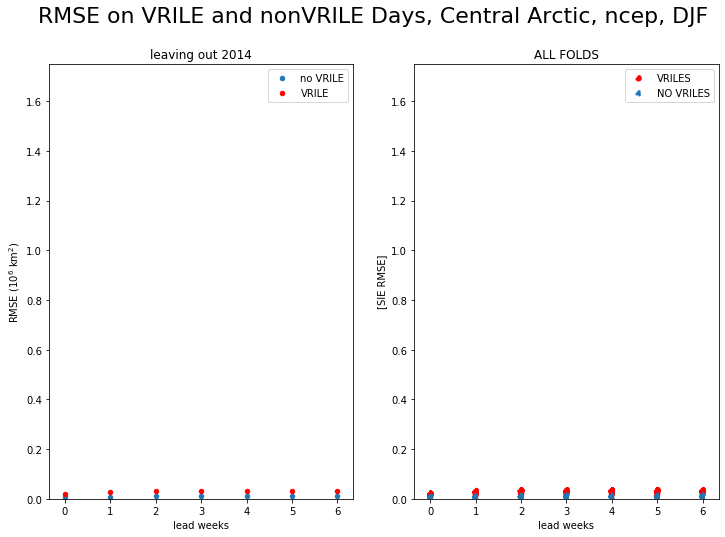

In [19]:
fig2,(ax2a,ax2b) = plt.subplots(1,2,figsize=(12,8))
reg_sel = 'Central Arctic'
SIE_errors_NO.xs(reg_sel).reset_index().plot.scatter(x='lead days',y='SIE RMSE',label='no VRILE',ax=ax2a)
SIE_errors.xs(reg_sel).reset_index().plot.scatter(x='lead days',y='SIE RMSE',color='r',label='VRILE',ax=ax2a)
ax2a.set_title('leaving out {iyr}'.format(iyr=iyr))
ax2a.set_xlabel('lead weeks')
ax2a.set_ylabel('RMSE (10$^6$ km$^2$)')
ax2a.set_ylim([0,1.75])
#
SIE_errors_ALL.xs(reg_sel).reset_index().plot.scatter(x='lead days',y=['SIE RMSE'],linewidth=2,linestyle='--',
                                    ax=ax2b,color='r',label='VRILES')
SIE_errors_NO_ALL.xs(reg_sel).reset_index().plot.scatter(x='lead days',y=['SIE RMSE'],linewidth=2,
                                            linestyle=':',ax=ax2b,label='NO VRILES')
ax2b.set_title('ALL FOLDS')
ax2b.set_xlabel('lead weeks')
ax2b.set_ylim([0,1.75])
fig2.suptitle('RMSE on VRILE and nonVRILE Days, {region}, {model_name}, {seas_str}'.format(region=reg_sel,
                                                                               model_name=model_name,seas_str=seas_str),fontsize=22)
figpath_save = '/home/disk/sipn/mcmcgraw/McGraw_etal_2020/code/make_it_nice/COMMON_LAND_MASK/figures/diagnostics/'
fpath_save_fig2 = figpath_save+'SIE_RMSE_all_slices_{reg_sel}_{model_name}_VRILES_{seas_str}.png'.format(reg_sel=reg_sel,model_name=model_name,
                                                                                                        seas_str=seas_str)
fig2.savefig(fpath_save_fig2,format='png',dpi=350,bbox_inches='tight')

Same figure but for anomalous SIE

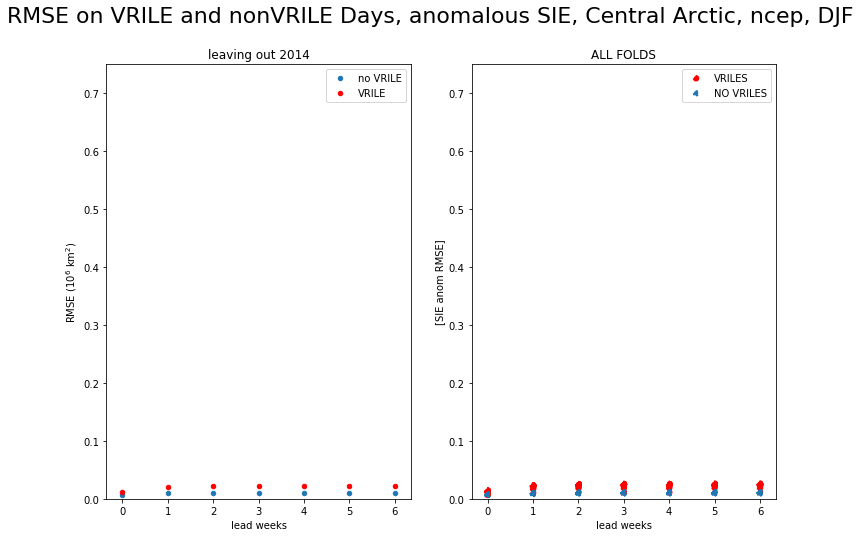

In [20]:
fig3,(ax3a,ax3b) = plt.subplots(1,2,figsize=(12,8))
SIE_errors_NO.xs(reg_sel).reset_index().plot.scatter(x='lead days',y='SIE anom RMSE',label='no VRILE',ax=ax3a)
SIE_errors.xs(reg_sel).reset_index().plot.scatter(x='lead days',y='SIE anom RMSE',color='r',label='VRILE',ax=ax3a)
ax3a.set_title('leaving out {iyr}'.format(iyr=iyr))
ax3a.set_xlabel('lead weeks')
ax3a.set_ylabel('RMSE (10$^6$ km$^2$)')
ax3a.set_ylim([0,0.75])
#
SIE_errors_ALL.xs(reg_sel).reset_index().plot.scatter(x='lead days',y=['SIE anom RMSE'],linewidth=2,linestyle='--',
                                    ax=ax3b,color='r',label='VRILES')
SIE_errors_NO_ALL.xs(reg_sel).reset_index().plot.scatter(x='lead days',y=['SIE anom RMSE'],linewidth=2,
                                            linestyle=':',ax=ax3b,label='NO VRILES')
ax3b.set_title('ALL FOLDS')
ax3b.set_xlabel('lead weeks')
ax3b.set_ylim([0,0.75])
fig3.suptitle('RMSE on VRILE and nonVRILE Days, anomalous SIE, {region}, {model_name}, {seas_str}'.format(region=reg_sel,
                                                                               model_name=model_name,seas_str=seas_str),fontsize=22)
fpath_save_fig3 = figpath_save+'SIE_anom_RMSE_all_slices_{reg_sel}_{model_name}_{seas_str}.png'.format(reg_sel=reg_sel,
                                                                            model_name=model_name,seas_str=seas_str)
fig3.savefig(fpath_save_fig3,format='png',dpi=350,bbox_inches='tight')

In [21]:
xx = SIE_errors_ALL.xs('Central Arctic').reset_index().groupby(['lead days']).mean()
yy = SIE_errors_NO.xs('Central Arctic').reset_index().groupby(['lead days']).mean()
SIE_errors_ALL['p-value']

region     lead days
Atlantic   0.0           61.774666
           1.0           92.443543
           2.0           88.902490
           3.0           97.953582
           4.0          111.330184
                           ...    
panArctic  2.0           85.195196
           3.0           82.493192
           4.0           61.561607
           5.0           69.908688
           6.0           81.102069
Name: p-value, Length: 2128, dtype: float64

In [22]:
SIE_anom_errors_ALL = SIE_anom_errors_ALL.rename(columns={'p-value':'p-value anom'})
SIE_anom_errors_NO_ALL = SIE_anom_errors_NO_ALL.rename(columns={'p-value':'p-value anom'})

Now, show p-value for each fold. 

No handles with labels found to put in legend.


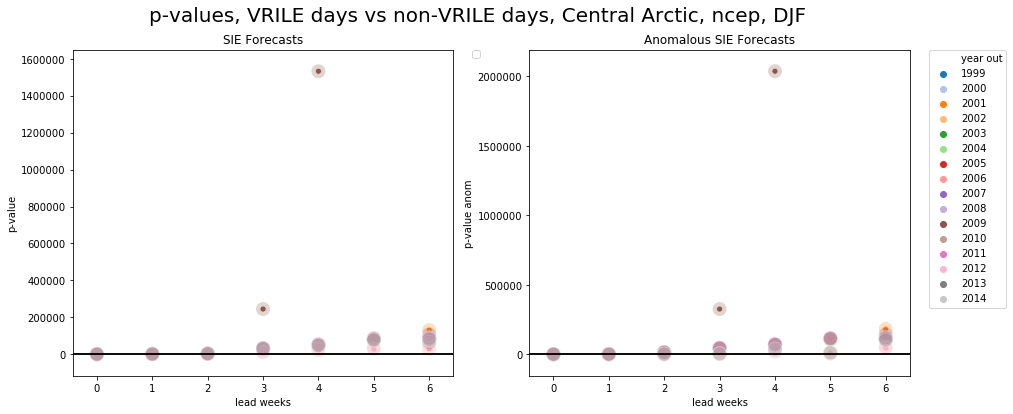

In [23]:
fig4,(ax4a,ax4b) = plt.subplots(1,2,figsize=(15,6))
foo = SIE_errors_ALL.xs(reg_sel).reset_index()
sp4a = sns.scatterplot(data=foo,x='lead days',y='p-value',hue='year out',ax=ax4a,palette='tab20',legend=False)
ax4a.axhline(-1.96,color='k')
ax4a.axhline(1.96,color='k')
SIE_errors_ALL_masked = SIE_errors_ALL.mask(SIE_errors_ALL['p-value'].abs()<1.96)
foo2 = SIE_errors_ALL_masked.xs(reg_sel).reset_index()
sns.scatterplot(data=foo2,x='lead days',y='p-value',hue='year out',s=200,legend=False,alpha=0.25,ax=ax4a,palette='tab20')
sp4a.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax4a.set_title('SIE Forecasts')
#
sp4b = sns.scatterplot(data=SIE_anom_errors_ALL.xs(reg_sel).reset_index(),x='lead days',
                       y='p-value anom',hue='year out',ax=ax4b,palette='tab20')
ax4b.axhline(-1.96,color='k')
ax4b.axhline(1.96,color='k')
SIE_anom_errors_ALL_masked = SIE_anom_errors_ALL.mask(SIE_anom_errors_ALL['p-value anom'].abs()<1.96)
sns.scatterplot(data=SIE_anom_errors_ALL_masked.xs(reg_sel).reset_index(),x='lead days',y='p-value anom',
                hue='year out',s=200,legend=False,alpha=0.25,ax=ax4b,palette='tab20')
sp4b.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax4b.set_title('Anomalous SIE Forecasts')
ax4b.set_xlabel('lead weeks')
ax4a.set_xlabel('lead weeks')
#
fig4.suptitle('p-values, VRILE days vs non-VRILE days, {reg_sel}, {model_name}, {seas_str}'.format(reg_sel=reg_sel,
                                                            model_name=model_name,seas_str=seas_str),fontsize=20)
fpath_save_fig4 = figpath_save+'pvalues_each_fold_{reg_sel}_{model_name}_{seas_str}.png'.format(reg_sel=reg_sel,
                                                                    model_name=model_name,seas_str=seas_str)
fig4.savefig(fpath_save_fig4,format='png',dpi=350,bbox_inches='tight')

Combine everything together into one data frame. Replace <code>SIE anom RMSE</code> and <code>SIE anom MAE</code> in <code>SIE_errors</code> with corresponding entries from  <code>SIE_anom_errors</code> (and same for raw)

In [24]:
SIE_errors_VRILE = SIE_errors_ALL.copy()
SIE_errors_VRILE = SIE_errors_VRILE.drop(columns={'SIE anom RMSE','SIE anom MAE'})
SIE_errors_VRILE = SIE_errors_VRILE.join(SIE_anom_errors_ALL[['SIE anom RMSE','SIE anom MAE','p-value anom']])
SIE_errors_VRILE['type'] = 'VRILE days'
#
SIE_errors_noVRILE = SIE_errors_NO_ALL.copy()
SIE_errors_noVRILE = SIE_errors_noVRILE.drop(columns={'SIE anom RMSE','SIE anom MAE'})
SIE_errors_noVRILE = SIE_errors_noVRILE.join(SIE_anom_errors_NO_ALL[['SIE anom RMSE','SIE anom MAE','p-value anom']])
SIE_errors_noVRILE['type'] = 'no VRILE days'
#
SIE_errors_FULL = SIE_errors_VRILE.append(SIE_errors_noVRILE)
##
SIE_anom_errors_VRILE = SIE_anom_errors_ALL.copy()
SIE_anom_errors_VRILE['type'] = 'VRILE days'
SIE_anom_errors_noVRILE = SIE_anom_errors_NO_ALL.copy()
SIE_anom_errors_noVRILE['type'] = 'no VRILE days'
SIE_anom_errors_FULL = SIE_anom_errors_VRILE.append(SIE_anom_errors_noVRILE)

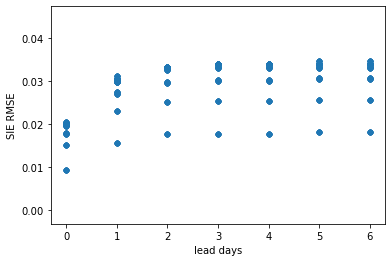

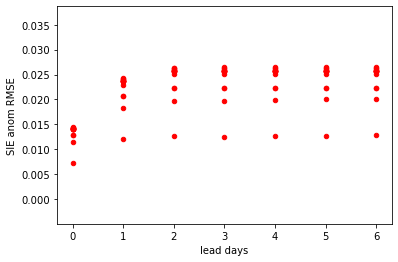

In [25]:
SIE_errors_VRILE.xs('Central Arctic').reset_index().plot.scatter(x='lead days',y='SIE RMSE')
SIE_anom_errors_VRILE.xs('Central Arctic').reset_index().plot.scatter(x='lead days',y='SIE anom RMSE',color='r')


Save files 

In [26]:
fdir = '/home/disk/sipn/mcmcgraw/McGraw_etal_2020/code/make_it_nice/COMMON_LAND_MASK/data/{model_name}/'.format(model_name=model_name)
fdir = fdir+'OBS_{obs_name}/'.format(obs_name=obs_name)
if COMMON_RF == True:
    fdir = fdir+'COMMON_RF/'
else:
    fdir = fdir+'FULL_TIME/'
if nday_change != 5:
    fdir = fdir+'VRILEs_{nday_change}day_change/'.format(nday_change=nday_change)
if not os.path.exists(fdir):
    os.makedirs(fdir)
#

fname_save_RMSE = fdir+'VRILE_vs_NOVRILE_RMSE_MAE_{model_name}_months{seas_str}_VRILE{thresh_str}_model_clim_freq_{clim_freq_str}.csv'.format(model_name=model_name,
                                             seas_str=seas_str,thresh_str=thresh_str,clim_freq_str=clim_freq_str)
#fname_save_raw = fdir+'RAW_err_{model_name}_months{seas_str}_VRILE{thresh_str}_model_clim_freq_{clim_freq_str}.csv'.format(model_name=model_name,
  #                                           seas_str=seas_str,thresh_str=thresh_str,clim_freq_str=clim_freq_str)
#
#SIE_raw_err_FULL.to_csv(fname_save_raw)
SIE_errors_FULL.to_csv(fname_save_RMSE)

In [27]:
print(fname_save_RMSE)

/home/disk/sipn/mcmcgraw/McGraw_etal_2020/code/make_it_nice/COMMON_LAND_MASK/data/ncep/OBS_NSIDC_0079/COMMON_RF/VRILE_vs_NOVRILE_RMSE_MAE_ncep_monthsDJF_VRILE05_model_clim_freq_WEEKLY.csv



SIE_errors_ALL['type'] = 'VRILE days'
SIE_anom_errors_ALL['type'] = 'VRILE days'
#SIE_errors_ALL = SIE_errors_ALL.reset_index()
#SIE_anom_errors_ALL = SIE_anom_errors_ALL.reset_index()
SIE_errors_ALL['SIE anom RMSE'] = SIE_anom_errors_ALL['SIE anom RMSE']
SIE_errors_ALL['SIE anom MAE'] = SIE_anom_errors_ALL['SIE anom MAE']
#SIE_errors_ALL['type'] = 'VRILE days'
SIE_errors_ALL = SIE_errors_ALL.reset_index()
#
SIE_errors_NO_ALL['type'] = 'no VRILE days'
SIE_anom_errors_NO_ALL['type'] = 'no VRILE days'
#SIE_errors_NO_ALL = SIE_errors_NO_ALL.reset_index()
#SIE_anom_errors_NO_ALL = SIE_anom_errors_NO_ALL.reset_index()
SIE_errors_NO_ALL['SIE anom RMSE'] = SIE_anom_errors_NO_ALL['SIE anom RMSE']
SIE_errors_NO_ALL['SIE anom MAE'] = SIE_anom_errors_NO_ALL['SIE anom MAE']
SIE_errors_NO_ALL = SIE_errors_NO_ALL.reset_index()

#
SIE_errors_FULL = SIE_errors_ALL.append(SIE_errors_NO_ALL)
# Same for raw errors
SIE_raw_err = SIE_raw_err.reset_index()
SIE_anom_raw_err = SIE_anom_raw_err.reset_index()
SIE_raw_err[['SIE anom']] = SIE_anom_raw_err['SIE anom']
SIE_raw_err['type'] = 'VRILE days'
#
SIE_raw_err_NO = SIE_raw_err_NO.reset_index()
SIE_anom_raw_err_NO = SIE_anom_raw_err_NO.reset_index()
SIE_raw_err_NO[['SIE anom']] = SIE_anom_raw_err_NO['SIE anom']
SIE_raw_err_NO['type'] = 'no VRILE days'
#
SIE_raw_err_FULL = SIE_raw_err.append(SIE_raw_err_NO)